# Lid Cavity Flow

## Set Up

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.mplot3d import Axes3D
import numba
from Diff_Func import laplace_operator_dx,laplace_operator_dy, finite_difference_u, finite_difference_v,neumann_bc, solve_pressure
from Diff_Func import finite_difference_u, finite_difference_v


iterration = 100000
tol = 1e-6
omega = 0.8
CFL = 0.5
# Gittergröße und Auflösung
Lx = Ly = 1.0  # Domain-Grösse
nx = ny = 41   # Auflösung
dx = Lx / (nx - 1) # Gitterabstand in x-Richtung
dy = Ly / (ny - 1) # Gitterabstand in y-Richtung
x = np.linspace(0.0, Lx, nx)
y = np.linspace(0.0, Ly, ny)
X, Y = np.meshgrid(x, y)
# Dichte und kinematische Viskosität
rho = 1.0     # kg/m^3
nu = 0.01       #kinematische Viskosität in m^2/s
step = 1e-3   # Schrittweite
# Randbedingungen
u = np.zeros((ny, nx)) # Geschwindigkeit
v = np.zeros((ny, nx)) # Geschwindigkeit
p = np.zeros((ny, nx)) # Druck

# Geschwindigkeit für r,l & u
u[:, 0] = 0   # links
u[:, -1] = 0  # rechts
u[0, :] = 0   # oben
v[0, :] = 0   # oben

# Geschwindigkeit für o
v[-1, :] = 0  # unten
u[-1, :] = 1  # unten 

# Druck für r,l,u,o
p[:, 0] = 0   # links (Neumann)
p[:, -1] = 0  # rechts (Neumann)
p[0, :] = 0   # oben 
p[-1, :] = 0  # unten (Neumann)

# Data Tracking

In [3]:
max_velocity_v = []
min_velocity_v = []
avg_velocity_v = []
avg_velocity_v = []
sum_velocity_v = []
velocity_mid_v = []
velocity_mid_u = []
sum_velocity_u = []

max_pressure = []
min_pressure = []
avg_pressure = []
sum_pressure = []


residual_pressure = []
residual_velocity_u = []
residual_velocity_v = []

Reynolds = []



# Chorin Methode

In [4]:
for i in range(iterration):
    du_dx = finite_difference_u(u,dx)
    du_dy = finite_difference_u(u,dy)
    dv_dx = finite_difference_v(v,dx)
    dv_dy = finite_difference_v(v,dy)
    #Schritt 01 - Lösen der Impulsgleichung ohne den Druck Gradienten
    
    u_temp = (u+ step * (-(u * du_dx+v * du_dy) +nu  * laplace_operator_dx(u,dx))) #
    v_temp = (v+ step * (-(u * dv_dy+v * dv_dy) +nu  * laplace_operator_dy(v,dy)))
    
    u_temp_dx = finite_difference_u(u_temp,dx)
    v_temp_dy = finite_difference_v(v_temp,dy)
    
    #Schritt 02 Berechnung der Druckgleichung zur Geschwindigkeitskorrektur
    rhs = (rho / step*(u_temp_dx +v_temp_dy))

    p_temp = solve_pressure(p, rhs, dx, max_iter=100000, omega=omega, tol=tol)
    p_dx = finite_difference_u(p_temp,dx)
    p_dy = finite_difference_v(p_temp,dy)
    print(i)
    #print("times step: ",step)
    #Schritt 03 - Lösen der Geschwindigkeitskorrektur (unter Beachtung der Geschwindigkeitsrandbedingungen):
    
    u_temp = ( u_temp -step / rho *p_dx)
    v_temp = (v_temp -step / rho *p_dy)
 
    residual_pressure.append(np.sum(np.abs(p_temp - p)))
    residual_velocity_u.append(np.sum(np.abs(u_temp - u)))
    residual_velocity_v.append(np.sum(np.abs(v_temp - v)))
    #print("r_p",residual_pressure[i],"r_u",residual_velocity_u[i],"r_v",residual_velocity_v[i])
    
    #Schritt 04 Update die Geschwindigkeiten und den Druck
    u = u_temp
    v = v_temp
    p = p_temp
    
    max_wave_speed = np.max(np.abs(u)) + np.max(np.abs(v))
    max_time_step = CFL * dx / max_wave_speed
    #print("max_time_step",max_time_step)
    step = min(step, max_time_step)
    if residual_velocity_u[i] < 1e-10:
        break
    
    #max_velocity_u.append(np.max(u))
    max_velocity_v.append(np.max(v))
    min_velocity_v.append(np.min(v))
    avg_velocity_v.append(np.median(v))
    avg_velocity_v.append(np.mean(v))
    max_pressure.append(np.max(p))
    avg_pressure.append(np.mean(p))
    min_pressure.append(np.min(p))
    sum_velocity_v.append(np.sum(v))
    sum_velocity_u.append(np.sum(u))
    sum_pressure.append(np.sum(p))
    Re = abs(rho * ((np.max(v)) * Lx)/ nu)
    
    
    #print("Reynolds number for the grid: ", Re)
    Reynolds.append(Re)
    #u/U-velocity at mid x/H, v/U-velocity at mid y/H, and pressure coefficient at the center of the cavity1.
    velocity_mid_v.append(v[int(ny/2),int(nx/2)])
    velocity_mid_u.append(u[int(ny/2),int(nx/2)])
    

    



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Visualisierung

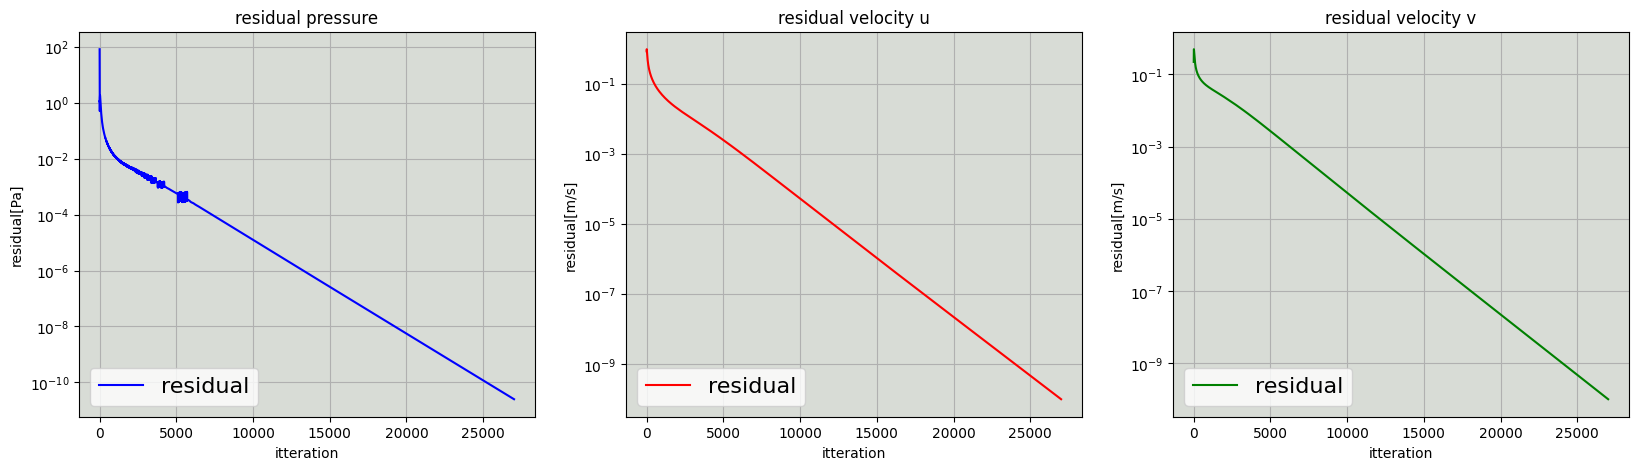

In [5]:
#plot all resiudals in one figure in three plots next to each other

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)

plt.plot(residual_pressure, label="residual",   color="blue")
plt.legend()
plt.title("residual pressure")
plt.xlabel("itteration")
plt.ylabel("residual[Pa]")
plt.grid(True)
ax = plt.gca()

ax.set_facecolor('xkcd:light grey')
# Add legend and axis labels
plt.legend(loc='lower left', fontsize=16)
#logarithmic scale
plt.yscale("log")


plt.subplot(1,3,2)

plt.plot(residual_velocity_u, label="residual", color="red")

plt.legend()
plt.title("residual velocity u")
plt.xlabel("itteration")
plt.ylabel("residual[m/s]")
plt.grid(True)
plt.yscale("log")
ax = plt.gca()

ax.set_facecolor('xkcd:light grey')
# Add legend and axis labels
plt.legend(loc='lower left', fontsize=16)

plt.subplot(1,3,3)
plt.plot(residual_velocity_v, label="residual", color="green")

plt.legend()
plt.title("residual velocity v")
plt.xlabel("itteration")
plt.ylabel("residual[m/s]")
plt.grid(True)
plt.yscale("log")
ax = plt.gca()

ax.set_facecolor('xkcd:light grey')
# Add legend and axis labels
plt.legend(loc='lower left', fontsize=16)

plt.savefig("images/residuals.png")
plt.show()

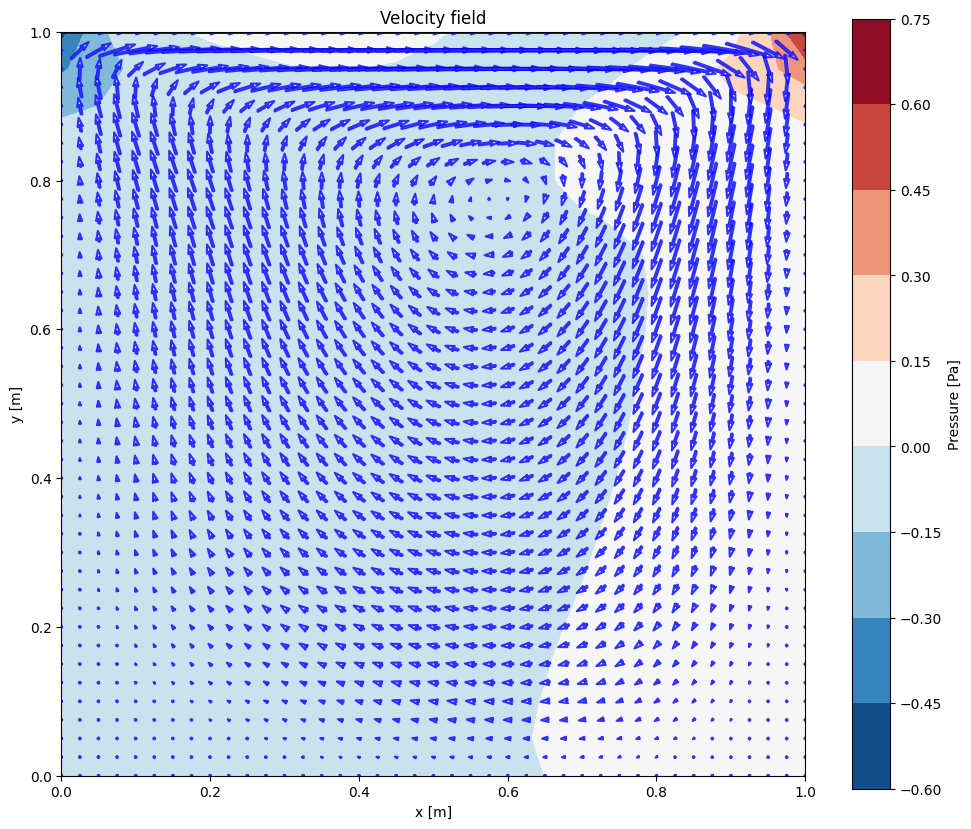

In [6]:
plt.figure(figsize=(12, 10))

# create a contour plot of the pressure field
plt.contourf(X[::2, ::2], Y[::2, ::2], p[::2, ::2], cmap='RdBu_r')
pc= plt.colorbar()
pc.set_label('Pressure [Pa]')
plt.title('Velocity field')

# create a quiver plot of the velocity field
plt.quiver(X[::1, ::1], Y[::1, ::1], u[::1, ::1], v[::1, ::1], 
           color="white", pivot="mid", scale=8, linewidths=1.5, edgecolors='blue', alpha=0.8,
           headlength=5, headaxislength=4, headwidth=3, units='xy')

# set the x and y limits of the plot to match the grid size
plt.xlim([X.min(), X.max()])
plt.ylim([Y.min(), Y.max()])

plt.xlabel('x [m]')
plt.ylabel('y [m]')
# set the aspect ratio of the plot to equal so that arrows are not distorted
plt.gca().set_aspect("equal")

# save and show the plot
plt.savefig("images/flow_field.png")
plt.show()

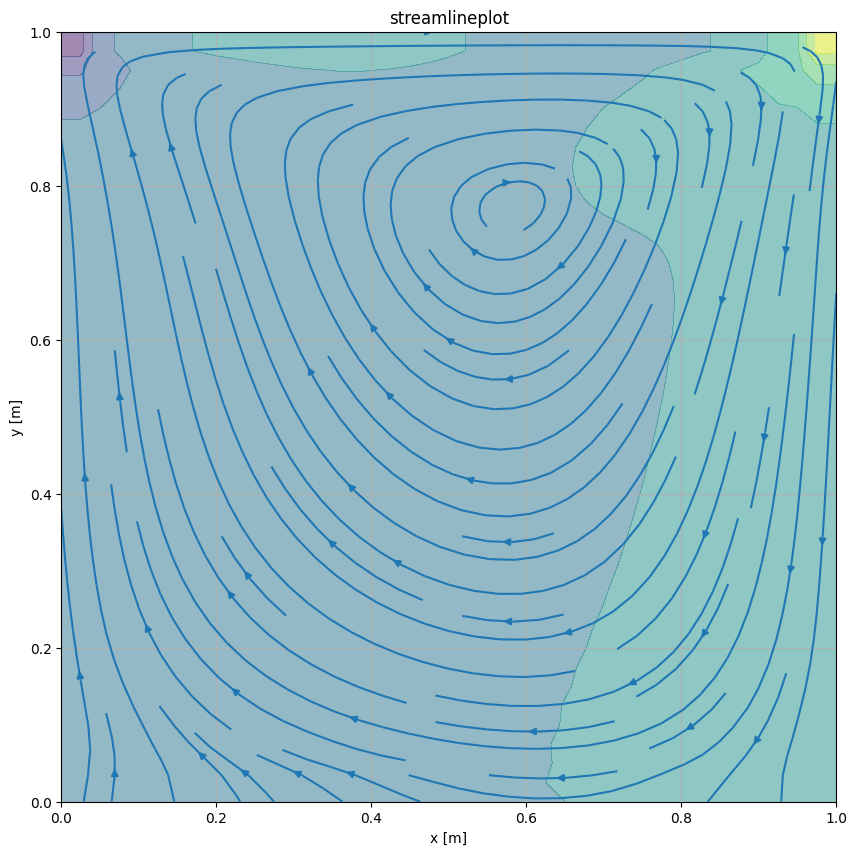

In [7]:
plt.figure(figsize=(10,10))

plt.streamplot(X, Y, u, v)
plt.title("streamlineplot")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.ylim(0,1)
plt.grid(True)
#add pressure in background
plt.contourf(X, Y, p, alpha=0.5, cmap=plt.cm.viridis)

# Show the plot
plt.savefig("images/streamlineplot.png")
plt.show()


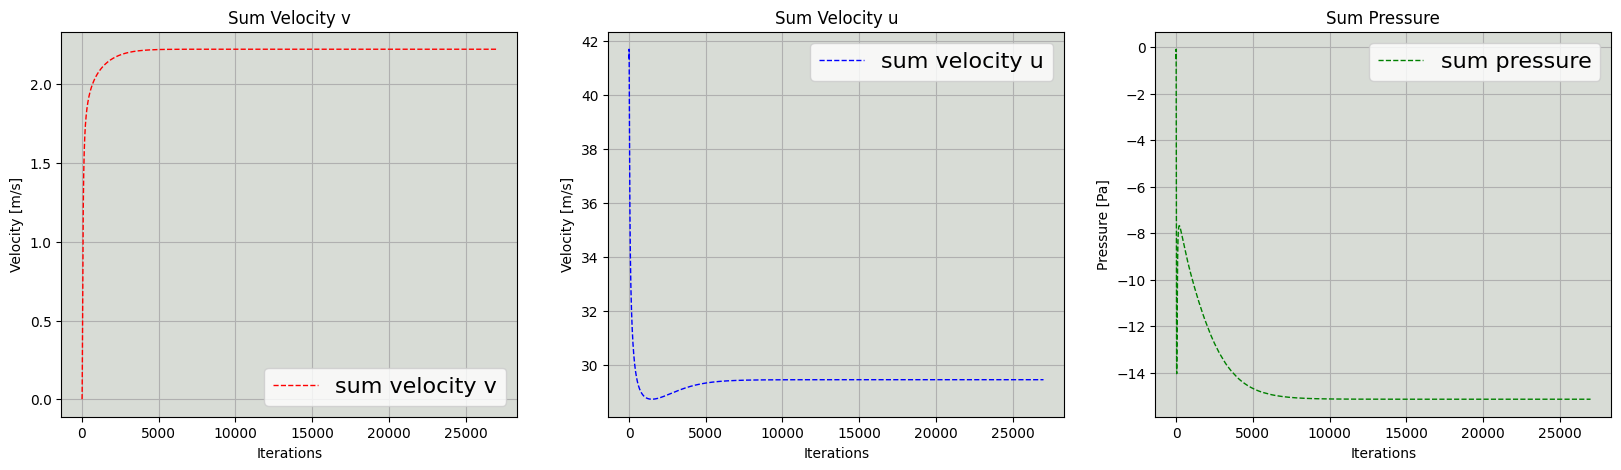

In [8]:
#plot the sum_velocity_v, sum_velocity_u and sum_pressure in one figure next to each other per iteration
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1,)
plt.plot(sum_velocity_v, color='red', linestyle='dashed', linewidth=1, markersize=12,label="sum velocity v")
plt.title('Sum Velocity v')
plt.ylabel('Velocity [m/s]')
plt.xlabel('Iterations')
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
# Add legend and axis labels
plt.legend(fontsize=16)
plt.grid(True)

plt.subplot(1, 3, 2,)
plt.plot(sum_velocity_u, color='blue', linestyle='dashed', linewidth=1, markersize=12,label="sum velocity u")
plt.title('Sum Velocity u')
plt.ylabel('Velocity [m/s]')
plt.xlabel('Iterations')
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
# Add legend and axis labels
plt.legend(fontsize=16)
plt.grid(True)

plt.subplot(1, 3, 3,)
plt.plot(sum_pressure, color='green', linestyle='dashed', linewidth=1, markersize=12,label="sum pressure")
plt.title('Sum Pressure')
plt.ylabel('Pressure [Pa]')
plt.xlabel('Iterations')
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
# Add legend and axis labels
plt.legend(fontsize=16)
plt.grid(True)
plt.savefig("images/sum.png")
plt.show()


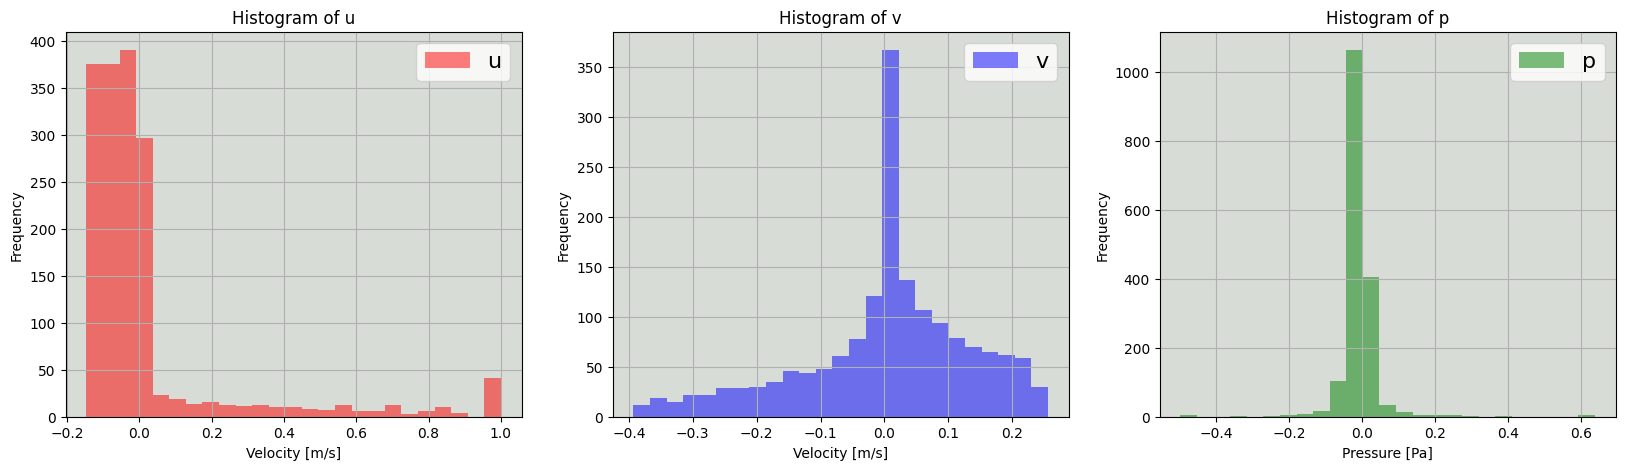

In [9]:
#plot the histogram of u,v,p in figure next to each other
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1,)
plt.hist(u.flatten(), bins=25, color='red', alpha=0.5, label="u")
plt.title('Histogram of u')
plt.ylabel('Frequency')
plt.xlabel('Velocity [m/s]')
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
# Add legend and axis labels
plt.legend(fontsize=16)
plt.grid(True)


plt.subplot(1, 3, 2,)
plt.hist(v.flatten(), bins=25, color='blue', alpha=0.5, label="v")
plt.title('Histogram of v')
plt.ylabel('Frequency')
plt.xlabel('Velocity [m/s]')
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
# Add legend and axis labels
plt.legend(fontsize=16)
plt.grid(True)

plt.subplot(1, 3, 3,)
plt.hist(p.flatten(), bins=25, color='green', alpha=0.5, label="p")
plt.title('Histogram of p')
plt.ylabel('Frequency')
plt.xlabel('Pressure [Pa]')
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
# Add legend and axis labels
plt.legend(fontsize=16)
plt.grid(True)
plt.savefig("images/histogram.png")
plt.show()


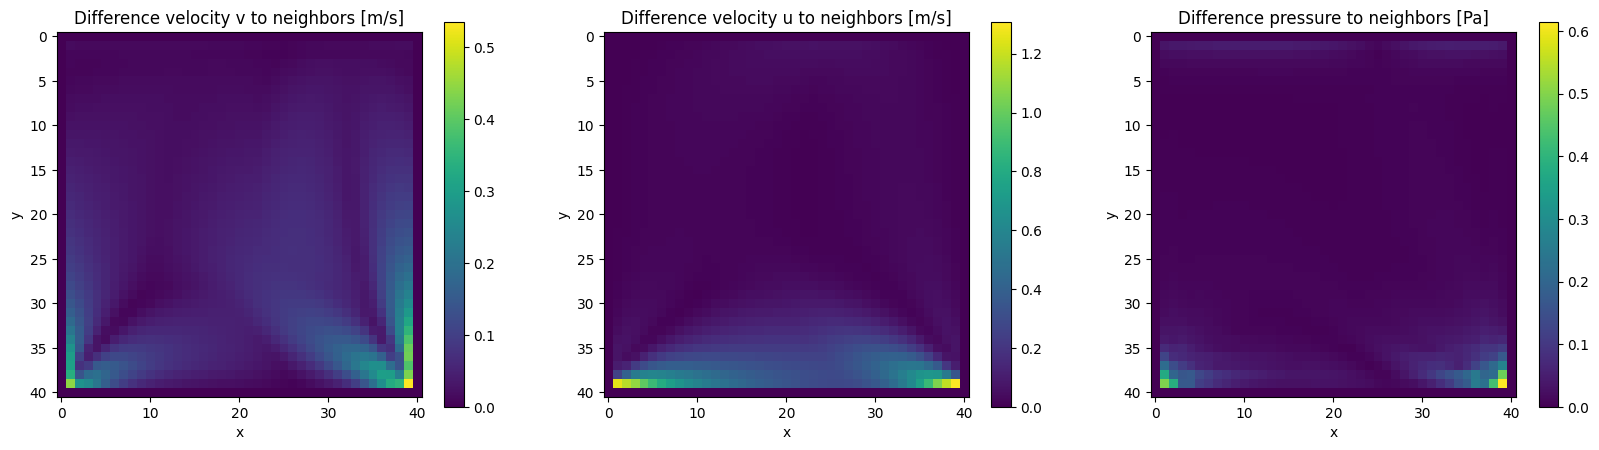

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1,)

diff_grid_v = np.zeros((41, 41)) # new grid to store differences

for i in range(1, 40):
    for j in range(1, 40):
        diff = 0
        diff += abs(v[i,j] - v[i-1,j]) # difference with top neighbor
        diff += abs(v[i,j] - v[i+1,j]) # difference with bottom neighbor
        diff += abs(v[i,j] - v[i,j-1]) # difference with left neighbor
        diff += abs(v[i,j] - v[i,j+1]) # difference with right neighbor
        diff_grid_v[i,j] = diff

plt.imshow(diff_grid_v)
plt.colorbar()
plt.title('Difference velocity v to neighbors [m/s]')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 3, 2,)
diff_grid_u = np.zeros((41, 41)) # new grid to store differences
for i in range(1, 40):
    for j in range(1, 40):
        diff = 0
        diff += abs(u[i,j] - u[i-1,j]) # difference with top neighbor
        diff += abs(u[i,j] - u[i+1,j]) # difference with bottom neighbor
        diff += abs(u[i,j] - u[i,j-1]) # difference with left neighbor
        diff += abs(u[i,j] - u[i,j+1]) # difference with right neighbor
        diff_grid_u[i,j] = diff
plt.imshow(diff_grid_u)

plt.colorbar()
plt.title('Difference velocity u to neighbors [m/s]')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 3, 3,)
diff_grid_p = np.zeros((41, 41)) # new grid to store differences
for i in range(1, 40):
    for j in range(1, 40):
        diff = 0
        diff += abs(p[i,j] - p[i-1,j]) # difference with top neighbor
        diff += abs(p[i,j] - p[i+1,j]) # difference with bottom neighbor
        diff += abs(p[i,j] - p[i,j-1]) # difference with left neighbor
        diff += abs(p[i,j] - p[i,j+1]) # difference with right neighbor
        diff_grid_p[i,j] = diff
plt.imshow(diff_grid_p)
plt.colorbar()
plt.title('Difference pressure to neighbors [Pa]')
plt.xlabel('x')
plt.ylabel('y')

plt.savefig("images/difference_components.png")
plt.show()



C:\Users\benit\AppData\Local\Temp\ipykernel_22000\1202729393.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax1.pcolormesh(freqs_x, freqs_y, psd_u)
C:\Users\benit\AppData\Local\Temp\ipykernel_22000\1202729393.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax2.pcolormesh(freqs_x, freqs_y, psd_v)


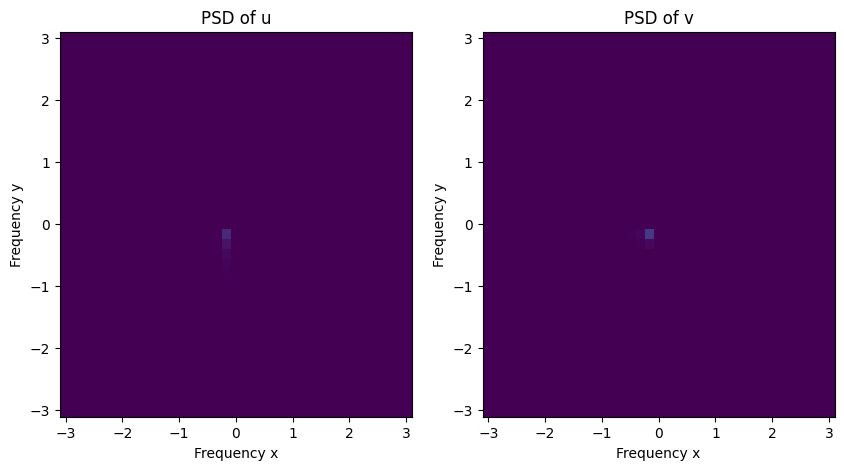

In [11]:
# Calculate PSD of u and v
uk = np.fft.fft2(u)
vk = np.fft.fft2(v)
psd_u = np.abs(uk)**2 / u.size**2
psd_v = np.abs(vk)**2 / v.size**2
freqs_x = np.fft.fftfreq(nx, d=2*np.pi/nx)
freqs_y = np.fft.fftfreq(ny, d=2*np.pi/ny)

# Plot PSDs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.pcolormesh(freqs_x, freqs_y, psd_u)
ax1.set_xlabel('Frequency x')
ax1.set_ylabel('Frequency y')
ax1.set_title('PSD of u')
ax2.pcolormesh(freqs_x, freqs_y, psd_v)
ax2.set_xlabel('Frequency x')
ax2.set_ylabel('Frequency y')
ax2.set_title('PSD of v')
plt.savefig("images/psd.png")
plt.show()

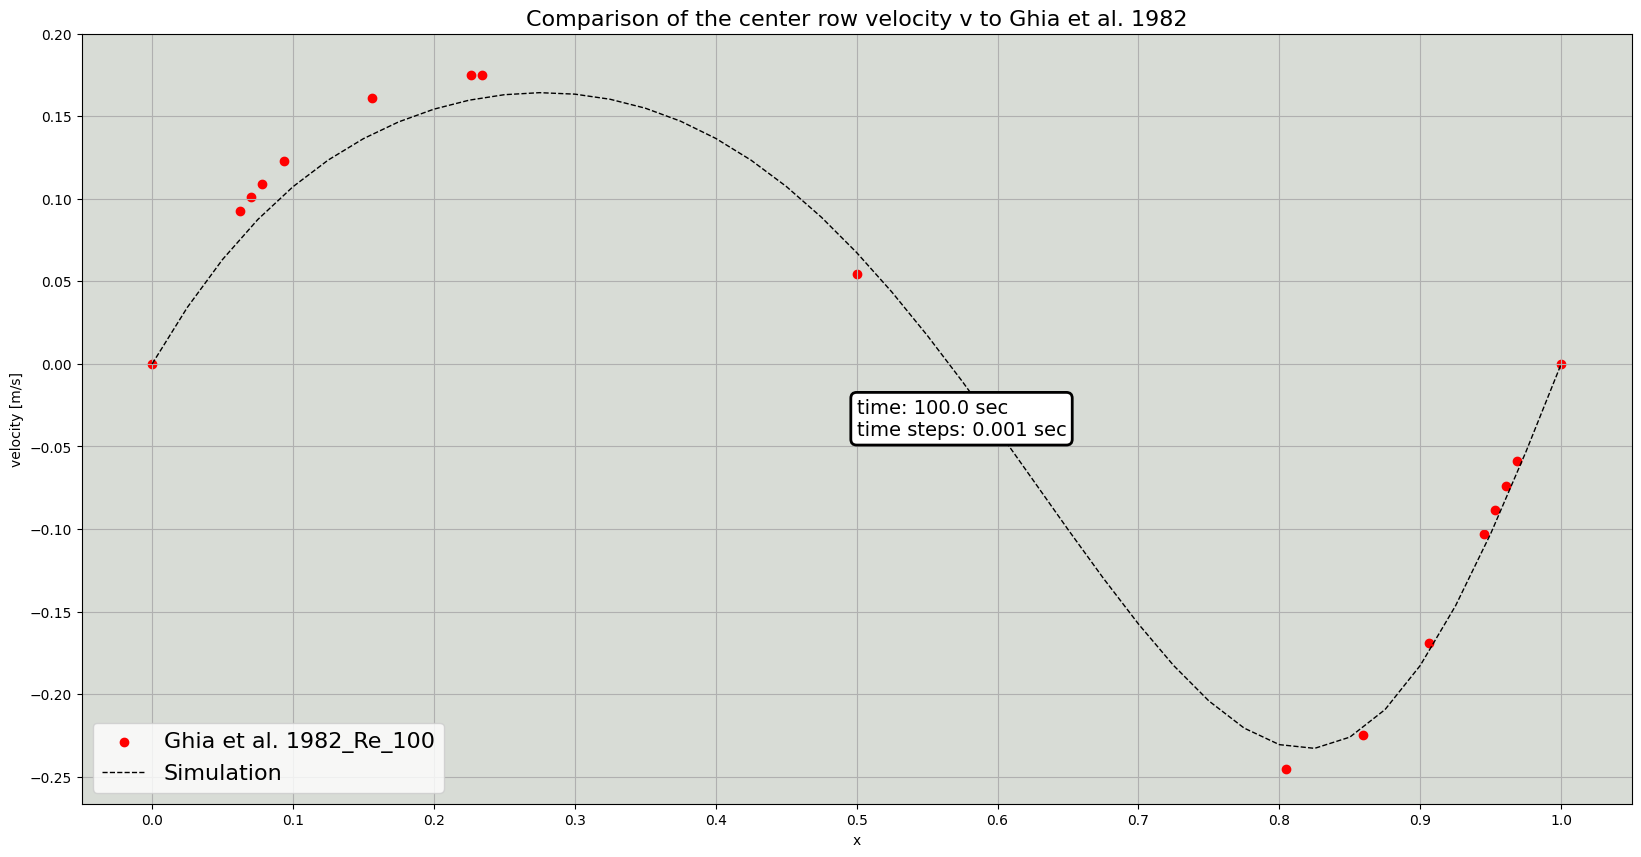

In [12]:

sec = iterration* step
df_v = pd.read_csv('ghiav_v.csv',sep=';')
df_v.head()
center_row_v = v[20,:]
#create values from 0 to 1 with 41 steps
x_center_row = np.linspace(0, 1, len(center_row_v))

# Interpolate the center row onto the x values from the DataFrame

plt.figure(figsize=(20,10))
# Plot the data from the DataFrame and the interpolated center row
plt.scatter(df_v['x'], df_v['Re_100'], label='Ghia et al. 1982_Re_100', marker = 'o',color='red' )
plt.plot(x_center_row, center_row_v, label='Simulation',color='black', linestyle='dashed', linewidth=1, markersize=12)
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(-0.25, 0.25, step=0.05))

# Add grid and legend
plt.grid(True)
#change background color

ax = plt.gca()

ax.set_facecolor('xkcd:light grey')
# Add legend and axis labels bottom left and make it bigger
plt.legend(loc='lower left', fontsize=16)
#resize the legend


plt.xlabel('x')
plt.ylabel('velocity [m/s]')
plt.title('Comparison of the center row velocity v to Ghia et al. 1982',  fontsize=16)
#add information for time (sec) and time setps (step)

text = 'time: '+str(sec)+' sec'+'\n'+'time steps: '+str(step) + ' sec'
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=2)

ax.text(0.5, 0.5, text, fontsize=14, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, bbox=bbox_props)

plt.savefig('images/Ghia_et_al_1982_Re_100_u.png')

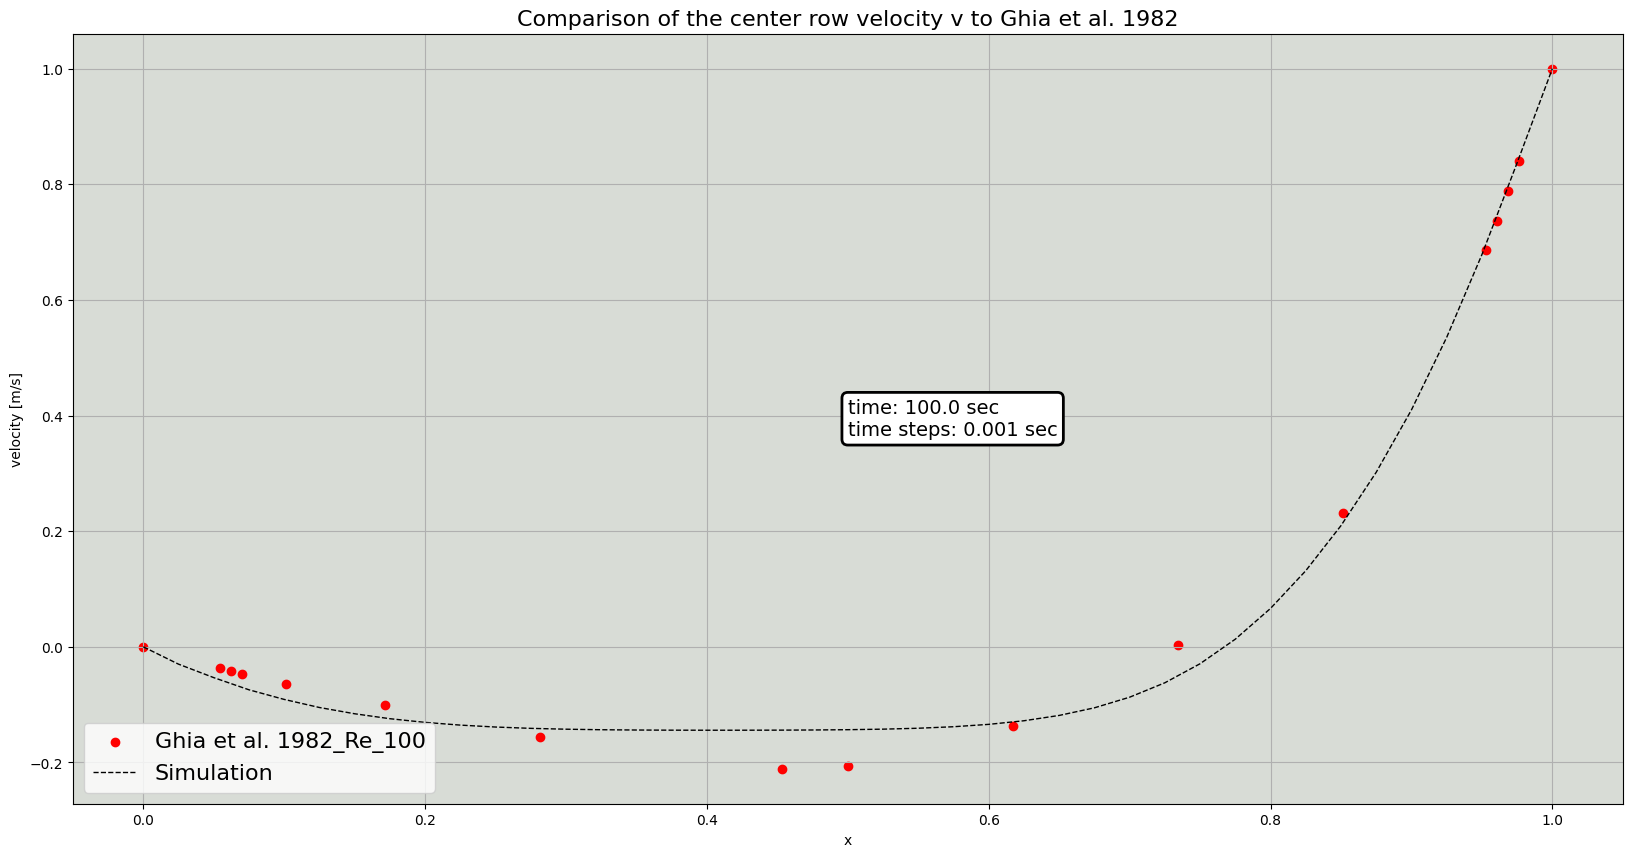

In [13]:
df_u = pd.read_csv('ghiav_u.csv',sep=';')
df_u.head()
center_row_u= u[:,20]
x_center_row_u = np.linspace(0, 1, len(center_row_u))

plt.figure(figsize=(20,10))
# Plot the data from the DataFrame and the interpolated center row
plt.scatter(df_u['y'], df_u['u'], label='Ghia et al. 1982_Re_100', marker = 'o',color='red' )
plt.plot(x_center_row_u, center_row_u, label='Simulation',color='black', linestyle='dashed', linewidth=1, markersize=12)

# Add a title and axis labels
#plt.xticks(np.arange(0, 1.1, step=0.1))
#plt.yticks(np.arange(-0.35, 0.25, step=0.05))
plt.grid(True)
#change background color

ax = plt.gca()

ax.set_facecolor('xkcd:light grey')
# Add legend and axis labels
plt.legend(loc='lower left', fontsize=16)
plt.xlabel('x')
plt.ylabel('velocity [m/s]')
plt.title('Comparison of the center row velocity v to Ghia et al. 1982',  fontsize=16)
#add information for time (sec) and time steps (step) in the center of the plot

text = 'time: '+str(sec)+' sec'+'\n'+'time steps: '+str(step) + ' sec'
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=2)

ax.text(0.5, 0.5, text, fontsize=14, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, bbox=bbox_props)

plt.savefig('images/Ghia_et_al_1982_Re_100_v.png')
